# Extended Causal Max Entropy Constraint Inference from IRL

In this notebook we extend the previous model as follows: 
1. Using Causal Max Entropy (Zeibart et al. 2010) which preserves the convergence guarantees for non-deterministic MDPs as well.
2. Extend the reward $R: S \times A \times S \to \mathbb{R}$ 
3. Extend the feature function $\phi: S \times A \times S \to \mathbb{R}^d$

### References
1. Ziebart, Brian D., J. Andrew Bagnell, and Anind K. Dey. "Modeling interaction via the principle of maximum causal entropy." ICML. 2010.

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import matplotlib

In [2]:
# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

In [3]:
import max_ent.examples.grid_9_by_9 as G
from max_ent.gridworld import Directions
%matplotlib notebook
np.random.seed(123)

In [4]:
def create_world(title, blue, green, cs=[], ca=[], cc=[], start=0, goal=8, vmin=-50, vmax=10):
    n_cfg = G.config_world(blue, green, cs, ca, cc, goal)
    n = n_cfg.mdp

    # Generate demonstrations and plot the world
    demo = G.generate_trajectories(n.world, n.reward, n.start, n.terminal)
    vmin = -50
    vmax = 10
    G.plot_world(title, n, n_cfg.state_penalties,
           n_cfg.action_penalties, n_cfg.color_penalties,
           demo, n_cfg.blue, n_cfg.green, vmin=vmin, vmax=vmax)   
    return n, n_cfg, demo

### Nominal world

<IPython.core.display.Javascript object>


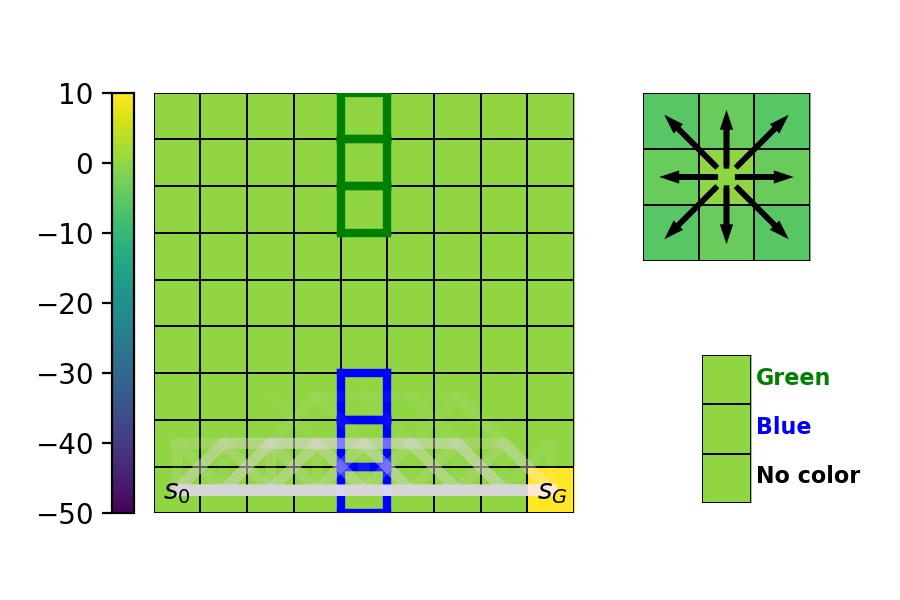

In [5]:
blue = [4, 13, 22]  # blue states
green = [58, 67, 76]  # green states

n, n_cfg, demo_n = create_world('Nominal', blue, green)

### Constrained world

<IPython.core.display.Javascript object>


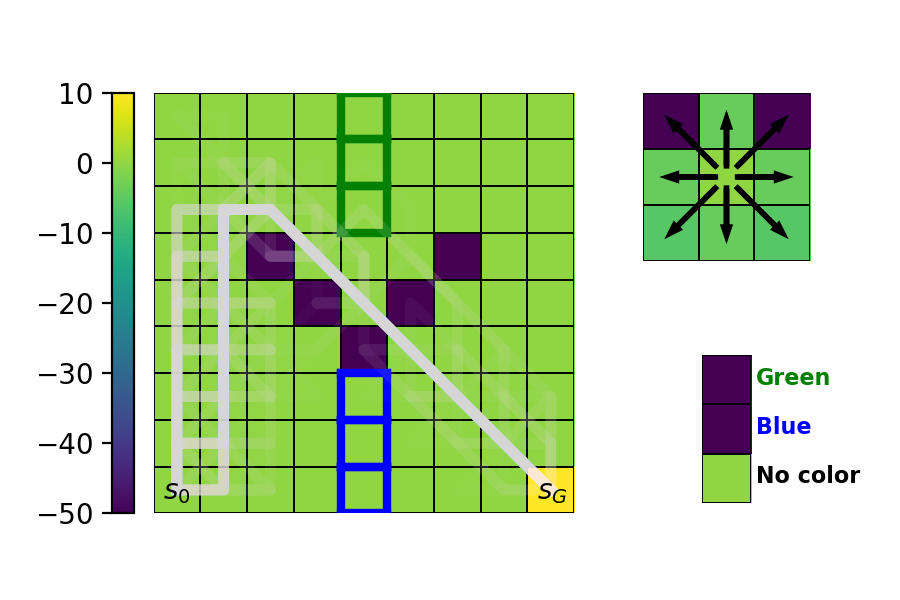

In [6]:
cs = [31, 39, 41, 47, 51]  # constrained states
ca = [Directions.UP_LEFT, Directions.UP_RIGHT]  # constrained actions
cc = [1, 2]  # constrained colors

c, c_cfg, demo_c = create_world('Constrained', blue, green, cs, ca, cc)

### Learn the constrains

In [7]:
learned_params = G.learn_constraints(n.reward, c.world, c.terminal, demo_c.trajectories)

         1: DELTA:  0.00000, MAE:  0.566611600957308
       101: DELTA:  0.20894, MAE:  0.177328392686315
       201: DELTA:  0.24373, MAE:  0.075571699533173
       301: DELTA:  0.11117, MAE:  0.043308011540981
       401: DELTA:  0.13639, MAE:  0.037143652784922


<IPython.core.display.Javascript object>


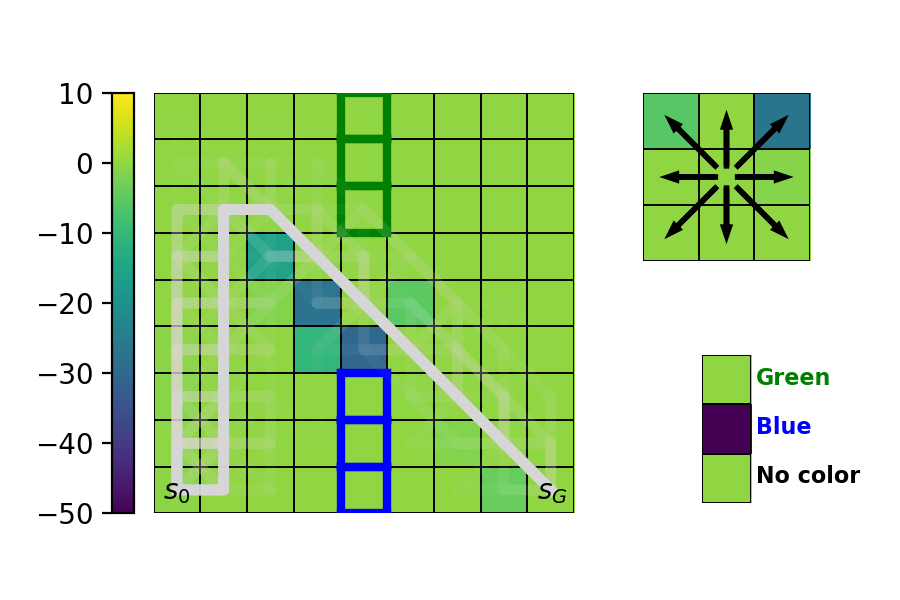

In [8]:
learned_mdp = G.MDP(c.world, learned_params.reward, c.terminal, c.start)
demo_l = G.generate_trajectories(c.world, learned_params.reward, c.start, c.terminal)
p = G.plot_world('Learned Constrained', learned_mdp, learned_params.state_weights, 
              learned_params.action_weights, learned_params.color_weights, 
              demo_l, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)

# Penalties to Probabilities

In [9]:
learned_mdp.reward.std(), n_cfg.mdp.reward.std(), learned_params.omega.std()

(16.560299443897968, 1.3804411697795096, 8.870026759070992)

In [10]:
np.sqrt((learned_mdp.reward.std() ** 2 + n_cfg.mdp.reward.std() ** 2)/2)

11.75051350994478

In [11]:
def convert_to_probs(w):
    w = -w # reward -> penalty
    # pooled std from both worlds
    s = np.sqrt((learned_mdp.reward.std() ** 2 + n_cfg.mdp.reward.std() ** 2)/2)
#     s = learned_mdp.reward.std()
    w =(w - s) / s
    return 1 / (1 + np.exp(-w))

In [12]:
w_c_s = learned_params.state_weights.copy()
p_c_s = convert_to_probs(w_c_s)

In [13]:
keys = list(learned_params.action_weights.keys())
w_c_a = np.array([learned_params.action_weights[a] for a in keys])
p_c_a = convert_to_probs(w_c_a)
a_probs = {keys[i]: p_c_a[i] for i in range(8)}

In [14]:
w_c_c = learned_params.color_weights

p_c_c = convert_to_probs(w_c_c)

<IPython.core.display.Javascript object>


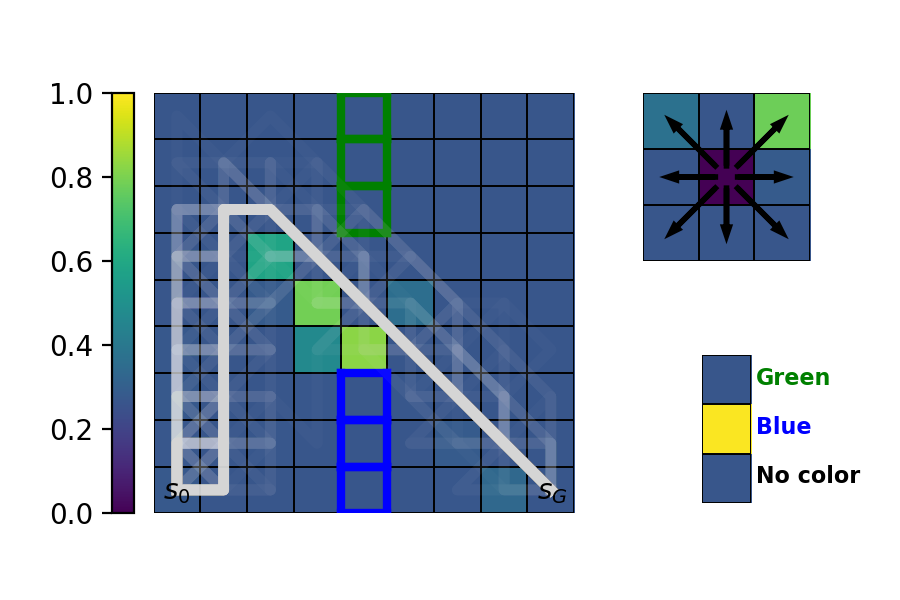

In [15]:
p = G.plot_world('Probs', learned_mdp, p_c_s, 
              a_probs, p_c_c, 
              demo_l, c_cfg.blue, c_cfg.green, vmin=0, vmax=1)

## Transfering the constraints
Lets make another constrained world where we have different constraints. 

In [ ]:
c2, c_cfg2, demo_c2 = create_world('Second Constrained', [3, 12, 21, 30, 31, 32, 33, 42, 51], green, cc=[1, 2])

Now lets use the learned color penalties in the previous constrained world alongside the reward from nominal world. 
Remember that the rewards in this world should be the nominal rewards minus the weighted combination of features in this world
$$
R_c(s, a, s') = R_n(s, a, s') - \omega_r^T \phi_c(s, a, s') 
$$


As we are only interested in the color constraints we set the weights for the other features to 0

In [ ]:
omega_color = np.copy(learned_params.omega) 
omega_color[:n.world.n_states] = 0 # Set the weight for the states to 0
omega_color[n.world.n_states: n.world.n_states + n.world.n_actions] = 0 # Set the weight for the actions to 0
reward = n.reward - c2.world.phi @ omega_color

Generate trajectories using this transfered reward on the new constrained world

In [ ]:
demo = G.generate_trajectories(c2.world, reward, c2.start, c2.terminal)
G.plot_world('Transfered Constraints', c2, c_cfg2.state_penalties,
           c_cfg2.action_penalties, learned_params.color_weights,
           demo, c_cfg2.blue, c_cfg2.green, vmin=-50, vmax=10)

## Composing a new world from learned constraints

Let assume that we learn the the state, action, and feature constraints separately. 
Can we compose a world using these learned constraints?

## Learn action constraints
We create a world that UP-RIGHT and RIGHT actions are constrained

In [ ]:
c_a, c_cfg_a, demo_a = create_world('Action Constrained', blue, green, 
                                    ca = [Directions.RIGHT, Directions.UP_RIGHT])

In [ ]:
learned_a = G.learn_constraints(n.reward, c_a.world, c_a.terminal, demo_a.trajectories)
mdp_a = G.MDP(c_a.world, learned_a.reward, c_a.terminal, c_a.start)

In [ ]:
demo = G.generate_trajectories(c_a.world, learned_a.reward, c_a.start, c_a.terminal)
G.plot_world('Learned Action Constrained', mdp_a, learned_a.state_weights, 
              learned_a.action_weights, learned_a.color_weights, 
              demo, c_cfg_a.blue, c_cfg_a.green, vmin=-50, vmax=10)

## Learn the color constrains
Blue states are constrained

In [ ]:
c_a, c_cfg_a, demo_a = create_world('Color Constrained', blue, green, cc = [1, 2])